In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('../') # path to bemcs

import bemcs
import bemcs.kernels_stress_displacement as kernels

class element_labels:
    def __init__(self):
        self.top = None
        self.right = None
        self.bot = None
        self.left = None
        self.interior = None

class geometry:
    def __init__(self, elements):
        n = len(elements)
        self.N = n
        self.x1 = np.zeros((n,1))
        self.x2 = np.zeros((n,1))
        self.y1 = np.zeros((n,1))
        self.y2 = np.zeros((n,1))
        self.xmid = np.zeros((n,1))
        self.ymid = np.zeros((n,1))
        self.nvec = np.zeros((n,2))
        self.svec = np.zeros((n,2))
        self.length = np.zeros((n,1))
        self.halflength = np.zeros((n,1))
        self.angle = np.zeros((n,1))

        for i in range(n):
            self.x1[i] = elements[i]["x1"]
            self.x2[i] = elements[i]["x2"]
            self.y1[i] = elements[i]["y1"]
            self.y2[i] = elements[i]["y2"]
            self.angle[i] = elements[i]["angle"]
            self.length[i] = elements[i]["length"]
            self.halflength[i] = elements[i]["half_length"]
            self.xmid[i] = elements[i]["x_center"]
            self.ymid[i] = elements[i]["y_center"]
            self.nvec[i,:] = np.array((elements[i]["x_normal"],elements[i]["y_normal"]))
            self.svec[i,:] = np.array((elements[i]["x_shear"],elements[i]["y_shear"]))
      

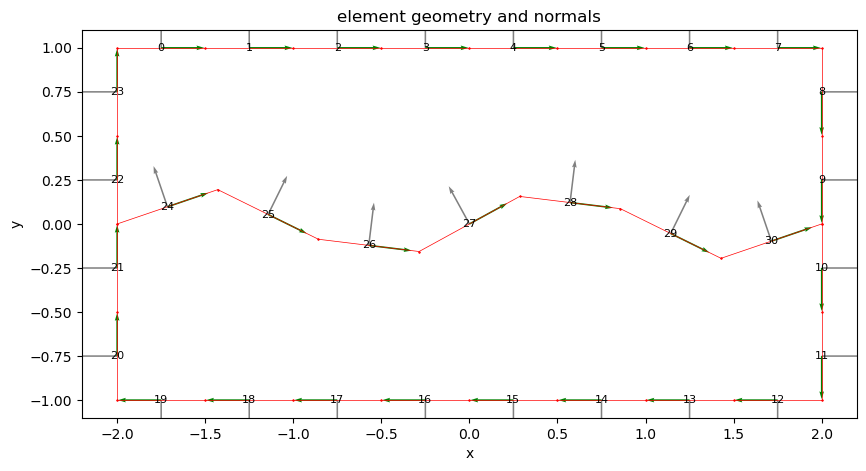

In [2]:
# Elastic parameters
mu = 1
nu = 0.25

# create a box mesh with a sinusoidal fault in the middle
L = 2
H = 1
ngrid = 2
corners = np.array([[-L, H], [L, H], [L, -H], [-L, -H], [-L, H]])

# Create arrays of the x and y coordinates of the corners
x, z = [], []
for i in range(4):
    lsegment = np.sqrt((corners[i,0]-corners[(i+1),0])**2 + (corners[i,1]-corners[(i+1),1])**2)
    xi = np.linspace(corners[i][0], corners[(i + 1) % 4][0], num=round(lsegment*ngrid/H), endpoint=False)
    zi = np.linspace(corners[i][1], corners[(i + 1) % 4][1], num=round(lsegment*ngrid/H), endpoint=False)
    x.append(xi)
    z.append(zi)
x.append(corners[0,0])
z.append(corners[0,1])
x = np.hstack(x)
z = np.hstack(z)

x1 = x[0:-1]
x2 = x[1:]
y1 = z[0:-1]
y2 = z[1:]
n_elements = len(x1)
elements = []
element = {}
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())


# Create a sinusoidal fault centered around y=0
x = np.linspace(-L,L,int(2*L/H*ngrid))
z = 0.2*H*np.sin(4*np.pi*x/2/L)
# force the first and last z-values to be 0
z[0] = 0
z[-1] = 0

x1 = x[0:-1]
x2 = x[1:]
y1 = z[0:-1]
y2 = z[1:]
n_elements = len(x1)
for i in range(n_elements):
    element["x1"] = x1[i]
    element["y1"] = y1[i]
    element["x2"] = x2[i]
    element["y2"] = y2[i]
    elements.append(element.copy())

elements = bemcs.standardize_elements(elements)
# convert elements to an object of geometry class
el_obj = geometry(elements)

n_elements = len(elements)

plt.figure(figsize=(10,6))
bemcs.plot_element_geometry(elements)
# plt.plot(elements_midpts[:,0],elements_midpts[:,1],'o')
plt.show()

In [3]:
# add labels for top,right,bot,left,interior
labels = element_labels()
labels.top = el_obj.ymid == H # top
labels.right = el_obj.xmid == L # right
labels.bot = el_obj.ymid == -H # top
labels.left = el_obj.xmid == -L # left
labels.interior = (el_obj.xmid>-L) & (el_obj.xmid<L) \
    & (el_obj.ymid>-H) & (el_obj.ymid<H) 

In [4]:
# first find all unique points
points = np.vstack((np.hstack((x1.reshape(-1,1),y1.reshape(-1,1))),np.hstack((x2.reshape(-1,1),y2.reshape(-1,1)))))

unique_points, id_unique = np.unique(points, axis = 0, return_index=True)

# find number of open, 2-overlap & triple junction nodes
index_matrix1 = []
index_matrix2 = []
index_matrix3 = []

for i in range(len(unique_points)):
    pts = unique_points[i,:].reshape(1,-1)
    
    # which element(s) contains this point 
    id1 = np.where(np.all(pts == np.hstack((x1.reshape(-1,1),y1.reshape(-1,1))), axis = 1))
    id2 = np.where(np.all(pts == np.hstack((x2.reshape(-1,1),y2.reshape(-1,1))), axis = 1))

    # the negative signs are for the triple junction equations 
    # s_1 + s_2 + s_3 = 0 with the negative sign going to any 2 elements that are both id1 or id2 
    if np.size(id1) == 2:
        id_combo = np.hstack((-id1[0]*3,id2[0]*3 + 2))
    elif np.size(id2) == 2:
        id_combo = np.hstack((id1[0]*3,-(id2[0]*3 + 2)))
    else:
        id_combo = np.hstack((id1[0]*3,id2[0]*3 + 2))

    if np.size(id_combo) == 1:
        index_matrix1.append(id_combo)
    elif np.size(id_combo) == 2:
        index_matrix2.append(id_combo)
    elif np.size(id_combo) == 3:
        index_matrix3.append(id_combo)
    else:
        raise ValueError("Cannot deal with more than 3 lines at a node")

print("Number of open nodes =", len(index_matrix1), ":", index_matrix1)
print("Number of 2-overlap nodes =", len(index_matrix2), ":", index_matrix2)
print("Number of triple junctions =", len(index_matrix3), ":", index_matrix3)

N_c = 2*len(elements) # central node equations
N_o = 2*len(index_matrix1) # open node equations
N_i = 4*len(index_matrix2) # overlapping node equations
N_t = 6*len(index_matrix3) # triple junction equations


Number of open nodes = 2 : [array([0]), array([20])]
Number of 2-overlap nodes = 6 : [array([3, 2]), array([6, 5]), array([9, 8]), array([12, 11]), array([15, 14]), array([18, 17])]
Number of triple junctions = 0 : []


In [5]:
# patch center locations (need to be shifted an infinitesimal amount in -ve unit normal direction)
obs_xy = (np.hstack((el_obj.xmid,el_obj.ymid)) - el_obj.nvec*1e-16)
x_obs = obs_xy[:,0].reshape(-1,1)
y_obs = obs_xy[:,1].reshape(-1,1)

In [6]:
# compute shear and tensile stress kernels
# kernels are [Kxx,Kyy,Kxy,Gx,Gy] x [Nobs x Ncoefficients]
# the last argument passed is a flag for shear/tensile source (1 - shear, 0 - tensile)
kernels_s = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,1)
kernels_n = kernels.get_quadratic_displacement_stress_kernel(x_obs,y_obs,elements,mu,nu,0)

# convert to traction kernels [Nobs x Ncoefficients]
# tx = Kxx*nx + Kxy*ny
# ty = Kxy*nx + Kyy*ny
tractionkernels_s = kernels.compute_tractionkernels(elements,kernels_s)
tractionkernels_n = kernels.compute_tractionkernels(elements,kernels_n)

# design matrices (in x,y coordinates) for slip and slip gradients at each 3qn
matrix_slip,matrix_slipgradient = kernels.get_designmatrix_xy_3qn(elements,flag = "node")

matrix_system = np.zeros((len(elements)*6,len(elements)*6))

/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:404: RuntimeWarning: divide by zero encountered in divide
  arctan_x_plus_a = np.pi / 2 * np.sign(y / (a + x)) - np.arctan(y / (a + x))
/Users/mallickrishg/Dropbox/scripts/Pythoncode/bemcs/examples/../bemcs/bemcs.py:403: RuntimeWarning: divide by zero encountered in divide
  arctan_x_minus_a = np.pi / 2 * np.sign(y / (a - x)) - np.arctan(y / (a - x))


In [7]:
# Boundary conditions are
# top: ux = 1, uy = 0
# right: traction-free
# bot: ux = -1, uy = 0
# left: traction-free
# interior: traction-free
bc_x = np.zeros((len(elements),1))
bc_y = np.zeros((len(elements),1))
bc_x[labels.top] = 1
bc_x[labels.bot] = -1

bc_x[labels.interior] = 0.1
bc_y[labels.interior] = -0.1

# boundary conditions
BCvector = np.zeros((len(elements)*6,1))
# slip OR slip gradients at the boundaries (we set them to 0 here)
BCvector[0:2] = 0.
BCvector[-2:] = 0.
# traction-free boundary condition for element centers
BCvector[2::6] = -bc_x
BCvector[3::6] = -bc_y

# ISSUE
Need to figure out how to label intersecting nodes, and then use the labels to apply appropriate operator & boundary conditions to these node pairs

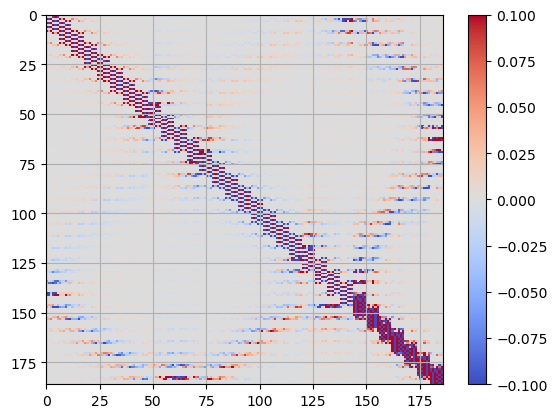

In [8]:

# Linear operator for BCs as a matrix
# boundary nodes (set to 0 slip)
matrix_system[0:2,:] = matrix_slipgradient[0:2:]
matrix_system[-2:,:] = matrix_slipgradient[-2:,:]

# patch center nodes (for x,y components)
matrix_tx = np.zeros((len(elements),6*len(elements)))
matrix_ty = np.zeros((len(elements),6*len(elements)))
matrix_tx[:,0::6] = tractionkernels_s[0][:,0::3]
matrix_tx[:,1::6] = tractionkernels_s[0][:,1::3]
matrix_tx[:,2::6] = tractionkernels_s[0][:,2::3]
matrix_tx[:,3::6] = tractionkernels_n[0][:,0::3]
matrix_tx[:,4::6] = tractionkernels_n[0][:,1::3]
matrix_tx[:,5::6] = tractionkernels_n[0][:,2::3]
matrix_ty[:,0::6] = tractionkernels_s[1][:,0::3]
matrix_ty[:,1::6] = tractionkernels_s[1][:,1::3]
matrix_ty[:,2::6] = tractionkernels_s[1][:,2::3]
matrix_ty[:,3::6] = tractionkernels_n[1][:,0::3]
matrix_ty[:,4::6] = tractionkernels_n[1][:,1::3]
matrix_ty[:,5::6] = tractionkernels_n[1][:,2::3]
matrix_system[2:-3:6,:] = matrix_tx # x component
matrix_system[3:-2:6,:] = matrix_ty # y component

# overlapping interior nodes (apply slip continuity and smoothness)
# continuity
matrix_system[4:-7:6,:] = matrix_slip[4:-7:6,:] - matrix_slip[6:-5:6,:]# x component
matrix_system[5:-6:6,:] = matrix_slip[5:-6:6,:] - matrix_slip[7:-4:6,:]# y component
# smoothness
matrix_system[6:-5:6,:] = matrix_slipgradient[4:-7:6,:] - matrix_slipgradient[6:-5:6,:]# x component
matrix_system[7:-4:6,:] = matrix_slipgradient[5:-6:6,:] - matrix_slipgradient[7:-4:6,:]# y component 

# plot design matrix
_,ax = plt.subplots()
pc = ax.pcolor(matrix_system,cmap="coolwarm",shading='flat')
# pc = ax.pcolor(kernels_s[2],cmap="coolwarm",shading='flat')
ax.grid(which='both')
ax.invert_yaxis()
pc.set_clim(-0.1,0.1)
plt.colorbar(pc)
plt.show()


In [9]:

# compute quadratic node coefficients (in local (s,n) coordinates)
quadratic_coefs = np.linalg.inv(matrix_system) @ BCvector

# extract (s,n) components and store them in 2 separate vectors
quadratic_coefs_s = np.zeros((len(elements)*3,1))
quadratic_coefs_n = np.zeros((len(elements)*3,1))
for i in range(len(elements)):
    quadratic_coefs_s[3*i:3*(i+1)] = quadratic_coefs[6*i:6*i+3]
    quadratic_coefs_n[3*i:3*(i+1)] = quadratic_coefs[6*i+3:6*(i+1)]
